<a href="https://colab.research.google.com/github/AedinMcCann/Thesis/blob/main/FINAL_AAPL_Rolling_Linear_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
pip install yfinance

In [ ]:
pip install yahoofinancials

In [ ]:
pip install pyfinance

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from yahoofinancials import YahooFinancials
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import pyfinance
from pyfinance import ols
import pandas_datareader as pdr
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

In [ ]:
# Get stock data
start='2020-01-01'
end='2021-01-02'
df = yf.download(tickers = "AAPL",start=start,end=end,interval = "60m")
df.reset_index(drop=False, inplace=True)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.tail()
df['Next_close'] = df['Close'].shift(-1)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Adj Close,Volume,Next_close
1760,2020-12-31 11:30:00-05:00,132.529999,132.800003,131.720001,132.619995,132.619995,13538948,132.560806
1761,2020-12-31 12:30:00-05:00,132.619995,132.717606,132.310104,132.560806,132.560806,7474176,132.764999
1762,2020-12-31 13:30:00-05:00,132.565002,132.889999,132.009995,132.764999,132.764999,9408857,132.800003
1763,2020-12-31 14:30:00-05:00,132.770004,133.179993,132.565994,132.800003,132.800003,10147999,132.580002
1764,2020-12-31 15:30:00-05:00,132.794998,133.330002,132.449997,132.580002,132.580002,11777361,NaN


In [ ]:
# Add in some technical indicators
# Simple moving average (SMA)
# 3 day period
Close = df[['Close']]
df['SMA'] = df.Close.rolling(3, min_periods=1).mean()

# Exponential moving average (EMA)
df['EMA'] = df.Close.ewm(alpha=0.1, adjust=False).mean()

In [ ]:
# On Balance Volume
# Measures cumulative buying and selling pressure by adding the volume on "up" days and subtracting volume on "down" days. 
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df = df.set_index('Datetime')
df

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv
Datetime,,,,,,,,,,
2020-01-02 09:30:00-05:00,74.059998,74.602501,73.797501,74.385002,74.385002,9941640,74.527496,74.385002,74.385002,0.0
2020-01-02 10:30:00-05:00,74.385002,74.687500,74.277496,74.527496,74.527496,4795404,74.571251,74.456249,74.399252,4795404.0
2020-01-02 11:30:00-05:00,74.525002,74.699997,74.362503,74.571251,74.571251,3345181,74.623474,74.494583,74.416451,8140585.0
2020-01-02 12:30:00-05:00,74.572502,74.688400,74.572502,74.623474,74.623474,1936326,74.672501,74.574074,74.437154,10076911.0
2020-01-02 13:30:00-05:00,74.625000,74.690002,74.514999,74.672501,74.672501,2432900,74.815353,74.622409,74.460688,12509811.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 11:30:00-05:00,132.529999,132.800003,131.720001,132.619995,132.619995,13538948,132.560806,132.678329,133.995014,532776914.0
2020-12-31 12:30:00-05:00,132.619995,132.717606,132.310104,132.560806,132.560806,7474176,132.764999,132.570267,133.851593,525302738.0
2020-12-31 13:30:00-05:00,132.565002,132.889999,132.009995,132.764999,132.764999,9408857,132.800003,132.648600,133.742934,534711595.0


In [ ]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv']]

In [ ]:
dataset = df.values
scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
y = dataset[:-1, 0]
x = pd.DataFrame(X)
y = pd.DataFrame(y)

In [ ]:
rolling = ols.PandasRollingOLS(y=y, x=X, window=130)
y_pred = rolling.predicted
y_pred = pd.DataFrame(y_pred)
y_pred

predicted
end  subperiod           
129  0           0.246518
     1           0.249186
     2           0.250458
     3           0.250755
     4           0.251768
...                   ...
1763 1759        0.941856
     1760        0.942006
     1761        0.939576
     1762        0.944769
     1763        0.943613

[212550 rows x 1 columns]

In [ ]:
y_pred = y_pred.reset_index()
counts= y_pred['subperiod'].value_counts()
y_pred = y_pred.groupby('subperiod').sum('predicted')
y_pred['predicted'] = y_pred['predicted']/counts
y_pred = y_pred.reset_index()
y_pred

,subperiod,end,predicted
0,0,129,0.246518
1,1,259,0.249105
2,2,390,0.250431
3,3,522,0.250796
4,4,655,0.251826
...,...,...,...
1759,1759,8805,0.941599
1760,1760,7046,0.941833
1761,1761,5286,0.939549
1762,1762,3525,0.944771


In [ ]:
df_y = y.reset_index()
df_y = df_y.rename(columns={'index':'period', 0:'actual'})
df_y

,period,actual
0,0,0.248536
1,1,0.249060
2,2,0.249685
3,3,0.250272
4,4,0.251983
...,...,...
1759,1759,0.944013
1760,1760,0.943305
1761,1761,0.945749
1762,1762,0.946169


In [ ]:
linear = df_y.join(y_pred, how='outer')
linear['difference'] = linear['actual'] - linear['predicted']
linear = linear.drop(['period','subperiod','end'], axis=1)
linear['sq_er'] = linear['difference']*linear['difference']
linear['AAPL_RMSE_LIN'] = np.sqrt(linear['sq_er'])
linear

,actual,predicted,difference,sq_er,AAPL_RMSE_LIN
0,0.248536,0.246518,0.002019,4.074671e-06,0.002019
1,0.249060,0.249105,-0.000045,1.984265e-09,0.000045
2,0.249685,0.250431,-0.000745,5.552318e-07,0.000745
3,0.250272,0.250796,-0.000523,2.736670e-07,0.000523
4,0.251983,0.251826,0.000156,2.437700e-08,0.000156
...,...,...,...,...,...
1759,0.944013,0.941599,0.002414,5.828728e-06,0.002414
1760,0.943305,0.941833,0.001472,2.166142e-06,0.001472
1761,0.945749,0.939549,0.006200,3.844092e-05,0.006200
1762,0.946169,0.944771,0.001398,1.953329e-06,0.001398


In [ ]:
MSE = linear['sq_er'].sum()/len(linear)
import math 
RMSE = math.sqrt(MSE)
RMSE

0.00999911683044092

## With sentiment

In [ ]:
df = df.reset_index()
df['date'] = df['Datetime'].dt.date  # for daily sentiment
df['datehour'] = df['Datetime'].dt.hour     #For hourly sentiment
df['hour_id'] = df['date'].map(str) + '.' + df['datehour'].map(str) 
df['hour_id']

0        2020-01-02.9
1       2020-01-02.10
2       2020-01-02.11
3       2020-01-02.12
4       2020-01-02.13
            ...      
1760    2020-12-31.11
1761    2020-12-31.12
1762    2020-12-31.13
1763    2020-12-31.14
1764    2020-12-31.15
Name: hour_id, Length: 1765, dtype: object

In [ ]:
sent = pd.read_excel('AAPL_sentiment_hr.xlsx')
df = pd.merge(df, sent, on = 'hour_id', how = 'left')
df = df.fillna(0)


In [ ]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv', 'average']]

dataset = df.values

scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
x = pd.DataFrame(X)
rolling = ols.PandasRollingOLS(y=y, x=X, window=130)
y_pred_sent = rolling.predicted
y_pred_sent = pd.DataFrame(y_pred_sent)
y_pred_sent = y_pred_sent.reset_index()
y_pred_sent = y_pred_sent.drop(['end'], axis=1)
y_pred_sent

,subperiod,predicted
0,0,0.246531
1,1,0.249399
2,2,0.251034
3,3,0.249727
4,4,0.251713
...,...,...
212545,1759,0.942534
212546,1760,0.941160
212547,1761,0.940096
212548,1762,0.944260


In [ ]:
rolling.predicted

end   subperiod
129   0            0.246531
      1            0.249399
      2            0.251034
      3            0.249727
      4            0.251713
                     ...   
1763  1759         0.942534
      1760         0.941160
      1761         0.940096
      1762         0.944260
      1763         0.943635
Name: predicted, Length: 212550, dtype: float64

In [ ]:
counts= y_pred_sent['subperiod'].value_counts()
y_pred_sent = y_pred_sent.groupby('subperiod').sum('predicted')
y_pred_sent['predicted_sent'] = y_pred_sent['predicted']/counts

In [ ]:
linear_sent = df_y.join(y_pred_sent, how='outer')
linear_sent = linear_sent.rename(columns = {0:'actual'})
linear_sent

,period,actual,index,predicted,predicted_sent
0,0,0.248536,0,0.246531,0.246531
1,1,0.249060,131,0.498636,0.249318
2,2,0.249685,393,0.753072,0.251024
3,3,0.250272,786,0.998858,0.249715
4,4,0.251983,1310,1.258860,0.251772
...,...,...,...,...,...
1759,1759,0.944013,1061435,4.711244,0.942249
1760,1760,0.943305,849410,3.763979,0.940995
1761,1761,0.945749,637254,2.820173,0.940058
1762,1762,0.946169,424967,1.888517,0.944259


In [ ]:
linear_sent['difference_sent'] = linear_sent['actual'] - linear_sent['predicted_sent']
linear_sent = linear_sent.drop(['predicted'], axis=1)
linear_sent['sq_er_sent'] = linear_sent['difference_sent']*linear_sent['difference_sent']
linear_sent['AAPL_RMSE_LIN_SENTIMENT'] = np.sqrt(linear_sent['sq_er_sent'])
linear_sent

,period,actual,index,predicted_sent,difference_sent,sq_er_sent,AAPL_RMSE_LIN_SENTIMENT
0,0,0.248536,0,0.246531,0.002005,4.020189e-06,0.002005
1,1,0.249060,131,0.249318,-0.000258,6.652025e-08,0.000258
2,2,0.249685,393,0.251024,-0.001338,1.791516e-06,0.001338
3,3,0.250272,786,0.249715,0.000558,3.110932e-07,0.000558
4,4,0.251983,1310,0.251772,0.000211,4.438794e-08,0.000211
...,...,...,...,...,...,...,...
1759,1759,0.944013,1061435,0.942249,0.001765,3.114078e-06,0.001765
1760,1760,0.943305,849410,0.940995,0.002310,5.336435e-06,0.002310
1761,1761,0.945749,637254,0.940058,0.005692,3.239558e-05,0.005692
1762,1762,0.946169,424967,0.944259,0.001910,3.647597e-06,0.001910


In [ ]:
MSE_sent = linear_sent['sq_er_sent'].sum()/len(linear_sent)
RMSE_sent = math.sqrt(MSE_sent)
RMSE_sent

0.009942199659185288

In [ ]:
AAPL_linear = pd.merge(linear, linear_sent, on = 'actual')
AAPL_linear

,actual,predicted,difference,sq_er,AAPL_RMSE_LIN,period,index,predicted_sent,difference_sent,sq_er_sent,AAPL_RMSE_LIN_SENTIMENT
0,0.248536,0.246518,0.002019,4.074671e-06,0.002019,0,0,0.246531,0.002005,4.020189e-06,0.002005
1,0.249060,0.249105,-0.000045,1.984265e-09,0.000045,1,131,0.249318,-0.000258,6.652025e-08,0.000258
2,0.249685,0.250431,-0.000745,5.552318e-07,0.000745,2,393,0.251024,-0.001338,1.791516e-06,0.001338
3,0.250272,0.250796,-0.000523,2.736670e-07,0.000523,3,786,0.249715,0.000558,3.110932e-07,0.000558
4,0.251983,0.251826,0.000156,2.437700e-08,0.000156,4,1310,0.251772,0.000211,4.438794e-08,0.000211
...,...,...,...,...,...,...,...,...,...,...,...
1855,0.944013,0.941599,0.002414,5.828728e-06,0.002414,1759,1061435,0.942249,0.001765,3.114078e-06,0.001765
1856,0.943305,0.941833,0.001472,2.166142e-06,0.001472,1760,849410,0.940995,0.002310,5.336435e-06,0.002310
1857,0.945749,0.939549,0.006200,3.844092e-05,0.006200,1761,637254,0.940058,0.005692,3.239558e-05,0.005692
1858,0.946169,0.944771,0.001398,1.953329e-06,0.001398,1762,424967,0.944259,0.001910,3.647597e-06,0.001910


In [ ]:
AAPL_linear.describe()

,actual,predicted,difference,sq_er,AAPL_RMSE_LIN,period,index,predicted_sent,difference_sent,sq_er_sent,AAPL_RMSE_LIN_SENTIMENT
count,1860.000000,1860.000000,1860.000000,1.860000e+03,1860.000000,1860.000000,1.860000e+03,1860.000000,1860.000000,1.860000e+03,1.860000e+03
mean,0.500660,0.500603,0.000057,9.809145e-05,0.006232,888.558065,1.295709e+07,0.500601,0.000059,9.706422e-05,6.188593e-03
std,0.260116,0.259900,0.009907,3.361641e-04,0.007700,512.114336,7.994948e+06,0.259906,0.009855,3.335876e-04,7.667930e-03
min,0.000000,0.008639,-0.076440,7.451379e-12,0.000003,0.000000,0.000000e+00,0.008501,-0.075796,8.229682e-14,2.868742e-07
25%,0.286996,0.287661,-0.003748,3.449485e-06,0.001857,441.750000,5.948735e+06,0.286991,-0.003728,3.180408e-06,1.783370e-03
50%,0.464551,0.462491,-0.000049,1.456016e-05,0.003816,891.500000,1.295378e+07,0.462894,-0.000045,1.393170e-05,3.732519e-03
75%,0.745355,0.747051,0.003847,5.845914e-05,0.007646,1339.250000,2.001376e+07,0.746722,0.003758,5.814369e-05,7.625197e-03
max,1.000000,1.003289,0.071419,5.843064e-03,0.076440,1763.000000,2.653294e+07,1.002548,0.071541,5.744967e-03,7.579556e-02


Text(0.5, 0.98, 'Root Mean Squared Error Distribution With Sentiment')

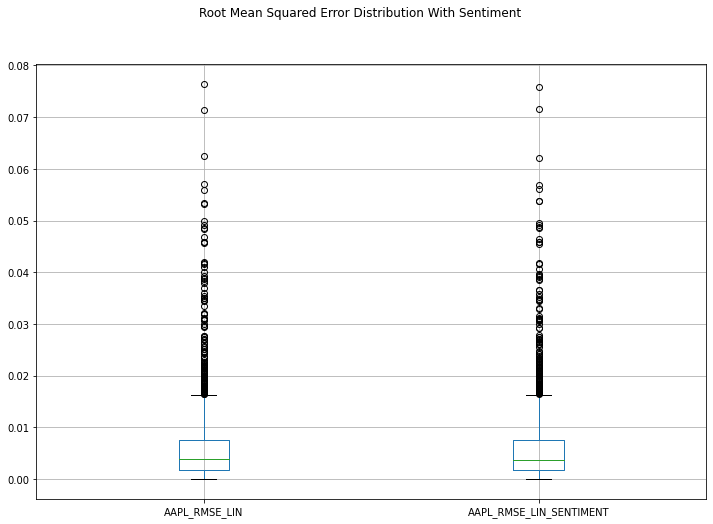

In [ ]:
boxplot = AAPL_linear.boxplot(column=['AAPL_RMSE_LIN', 'AAPL_RMSE_LIN_SENTIMENT'],figsize=(12,8))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(boxplot).reshape(-1)]
fig = np.asarray(boxplot).reshape(-1)[0].get_figure()
fig.suptitle('Root Mean Squared Error Distribution With Sentiment')

In [ ]:
AAPL_linear_RMSE = AAPL_linear[['AAPL_RMSE_LIN', 'AAPL_RMSE_LIN_SENTIMENT']]
AAPL_linear_RMSE.describe()

,AAPL_RMSE_LIN,AAPL_RMSE_LIN_SENTIMENT
count,1860.000000,1.860000e+03
mean,0.006232,6.188593e-03
std,0.007700,7.667930e-03
min,0.000003,2.868742e-07
25%,0.001857,1.783370e-03
50%,0.003816,3.732519e-03
75%,0.007646,7.625197e-03
max,0.076440,7.579556e-02


In [ ]:
AAPL_linear_RMSE.to_csv('AAPL_Linear_Comms_Results.csv')